<a href="https://colab.research.google.com/github/sankirnajoshi/sentiment-app/blob/master/sentiment_app_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment-app model
This notebook is used to train the LSTM model for the sentiment app.

## Load Data

In [0]:
import urllib.request
import sys
import zipfile
import pandas as pd
from bs4 import BeautifulSoup
import nltk
#from nltk.corpus import  stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from os import path
import numpy as np


import warnings
warnings.filterwarnings("ignore")

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/wordnet')
except:
    nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

url = 'http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip'

def download_url(url, save_path):
    '''
    Download the zip file from stanford website
    '''
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())


def dataset_preparation(filename, header=None):
    '''
    Extract the downloaded zip with the folder structure intact. 
    ##To Do - optimize the function to remove folder structure and download only the required files.
    '''
    data = pd.read_csv(filename, sep="|", header=header)
    return data    


def target_map(target):
    '''
    Apply function to target to get ratings in 
    desired form. Ratings will be converted from 
    [0, 0.2], (0.2, 0.4], (0.4, 0.6], (0.6, 0.8], (0.8, 1.0]
    to [0,1,2,3,4]. The new ratings are defined as :
    0 - very negative
    1 - somewhat negative
    2 - neutral
    3 - somewhat positive
    4 - very positive
    '''
    if 0 <= target <= 0.2:
        return 0
    elif 0.2 < target <=0.4:
        return 1
    elif 0.4 < target <=0.6:
        return 2
    elif 0.6 < target <=0.8:
        return 3
    else:
        return 4

def clean_data(df, col):
    ##Remove records without any words
    #df[col] = pd.Series([BeautifulSoup(text).get_text() for text in df[col]])
    df[col] = df[df[col].str.contains('[A-Za-z]')] #remove rows without any alphabets.
    df[col] = df[col].str.replace('[^\w\s]','').str.lower().str.strip() #replace punctuations, remove case and strip whitespaces
    df[col] = df[col].replace('', np.NaN)
    df = df.drop_duplicates(subset=[col])
    df = df.dropna(subset=[col])
    df[col] = df[col].dropna()
    df[col] = df[col].apply(lambda x: word_tokenize(x))
    df[col] = df[col].apply(lambda x : [lemmatizer.lemmatize(item) for item in x])
    return df

if not path.exists('../data'):
    download_url(url,'../data.zip')
    with zipfile.ZipFile('../data.zip', 'r') as zip_ref:
        zip_ref.extractall('../data/')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
run = False
if run:
    dictionary = dataset_preparation('../data/stanfordSentimentTreebank/dictionary.txt')
    dictionary.columns = ['phrase','phrase_id']

    sentiment = dataset_preparation('../data/stanfordSentimentTreebank/sentiment_labels.txt', header=0)
    sentiment.columns=['phrase_id','target']

    data = pd.merge(dictionary, sentiment, how='inner',on='phrase_id')

    data['target'] = data['target'].map(target_map)
    df = clean_data(data, 'phrase')
    df.to_pickle('../data/merged_cleaned_data.pkl')
    del data, dictionary, sentiment;
else:
    df = pd.read_pickle('https://github.com/sankirnajoshi/sentiment-app/raw/master/model/merged_cleaned_data.pkl')

In [0]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM,Flatten,MaxPooling1D,Conv1D,Bidirectional

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import  categorical_crossentropy
from tensorflow.keras.optimizers import Adam

#set random seed for the session and also for tensorflow that runs in background for keras
import random
tf.random.set_seed(0)
random.seed(0)

In [0]:
from sklearn.model_selection import train_test_split
X = df.phrase
y = df.target
y = to_categorical(y) #one hot encode y

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

del X_train_val, y_train_val;

In [0]:
unique_words = set(np.hstack(X_train))
print(f'Unique words : {len(unique_words)}')

Unique words : 17873


Mean length: 
6.76 +- 6.42 words


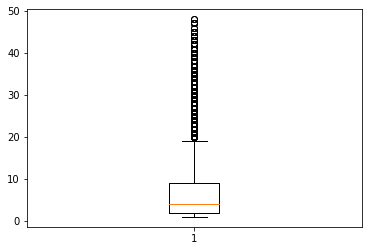

In [0]:
import matplotlib.pyplot as plt
# Summarize review length
print("Mean length: ")
result = [len(x) for x in X_train]
print(f'{np.mean(result):.2f} +- {np.std(result):.2f} words')
# plot review length
plt.boxplot(result)
plt.show();

max length: 48


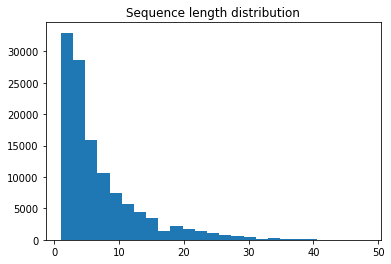

In [0]:
MAX_LENGTH = max(map(len, X_train))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, X_train)), bins=25);

In [0]:
tokenizer = Tokenizer(num_words=len(list(unique_words)),oov_token='#')
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(list(X_train))
X_val = tokenizer.texts_to_sequences(list(X_val))
X_test = tokenizer.texts_to_sequences(list(X_test))

X_train = sequence.pad_sequences(X_train, maxlen=MAX_LENGTH)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LENGTH)

print(X_train.shape,X_val.shape,X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(119853, 48) (39951, 48) (39951, 48)
(119853, 5) (39951, 5) (39951, 5)


In [0]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_accuracy', patience = 2)
callback = [early_stopping]

## Train Model

In [0]:
num_classes = 5
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=MAX_LENGTH))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 300)           5361900   
_________________________________________________________________
lstm_4 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 5,631,281
Trainable params: 5,631,281
Non-trainable params: 0
____________________________________________

In [0]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/6
469/469 [==============================] - 191s 406ms/step - loss: 1.1465 - accuracy: 0.5493 - val_loss: 0.9503 - val_accuracy: 0.6137
Epoch 2/6
469/469 [==============================] - 186s 398ms/step - loss: 0.8881 - accuracy: 0.6433 - val_loss: 0.8590 - val_accuracy: 0.6488
Epoch 3/6
469/469 [==============================] - 184s 393ms/step - loss: 0.8027 - accuracy: 0.6768 - val_loss: 0.8524 - val_accuracy: 0.6541
Epoch 4/6
469/469 [==============================] - 183s 390ms/step - loss: 0.7583 - accuracy: 0.6926 - val_loss: 0.8382 - val_accuracy: 0.6564
Epoch 5/6
469/469 [==============================] - 182s 388ms/step - loss: 0.7242 - accuracy: 0.7074 - val_loss: 0.8484 - val_accuracy: 0.6588
Epoch 6/6
469/469 [==============================] - 182s 387ms/step - loss: 0.6999 - accuracy: 0.7160 - val_loss: 0.8671 - val_accuracy: 0.6567


## Model Performance

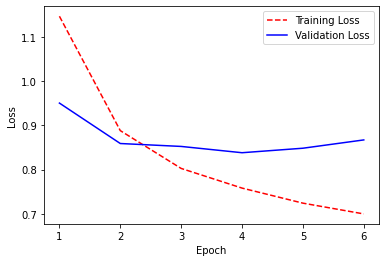

Accuracy: 65.92%


In [0]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [0]:
from tensorflow.keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("../data/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("../data/model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
print("End of training")

End of training


## Predictions
To run predictions on user input, visit the below notebook:

https://colab.research.google.com/drive/1iZwb5IfE-JBoFXtiVVpUi89tbT4hbUP2

## Other Models

In [0]:
## Model 2 Bidirectional LSTM
num_classes = 5
model_1=Sequential()
model_1.add(Embedding(len(list(unique_words)),64,input_length=MAX_LENGTH))
model_1.add(Bidirectional(LSTM(64,dropout=0.3, recurrent_dropout=0.3,return_sequences=True)))
model_1.add(Dropout(0.3))
model_1.add(Bidirectional(LSTM(64,dropout=0.5, recurrent_dropout=0.3,return_sequences=False)))
model_1.add(Dropout(0.3))
model_1.add(Dense(32,activation='relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(num_classes,activation='softmax'))
model_1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 48, 64)            1143872   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 48, 128)           66048     
_________________________________________________________________
dropout_12 (Dropout)         (None, 48, 128)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)               

In [0]:
history=model_1.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/6
469/469 [==============================] - 331s 706ms/step - loss: 1.0283 - accuracy: 0.5871 - val_loss: 0.8709 - val_accuracy: 0.6385
Epoch 2/6
469/469 [==============================] - 328s 698ms/step - loss: 0.8218 - accuracy: 0.6621 - val_loss: 0.8372 - val_accuracy: 0.6517
Epoch 3/6
469/469 [==============================] - 313s 667ms/step - loss: 0.7467 - accuracy: 0.6898 - val_loss: 0.8609 - val_accuracy: 0.6524
Epoch 4/6
469/469 [==============================] - 309s 660ms/step - loss: 0.6943 - accuracy: 0.7073 - val_loss: 0.8716 - val_accuracy: 0.6476


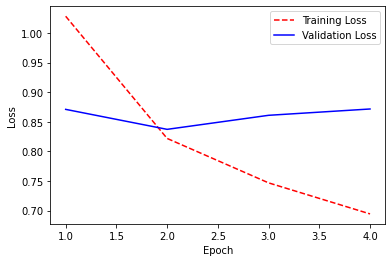

Accuracy: 65.28%


In [0]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
scores = model_1.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))